In [49]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import random

In [96]:
class Node:
    '''
    Class defining a node in graph

    Attributes:
        infected (bool): Describes if node is infected or not,
        index (int): Represents node index
    '''
    def __init__(self, infected, index):
        self.infected = infected
        self.index = index
    
    def __repr__(self):
        return repr(self.index) + ": " + repr(self.infected)

class Graph:
    '''
    Class defining a graph

    Attributes:
        n (int): The number of nodes,
        links (list): List of connections between nodes
    '''
    def __init__(self, n, p):
        '''Creates a graph with n vertices by randomly connecting pairs

        Args:
            n (int): The number of nodes,
            p (float): The probability of connecting two nodes

        '''
        self.links = [[Node(False, i)] for i in range(n)]
        for a in self.links:
            for b in self.links:
                if (a != b) and (random.random() < p) and (a[0] not in b):
                    a.append(b[0])
                    b.append(a[0])
                    
    
    def infect(self, n, infect_p):
        '''Selects random node as patient zero and performs the infection process among all vertices. New and total
        cases are stored in appropiate lists.

        Args:
            n (int): The number of iterations,
            infect_p (float): The infection probability

        '''
        new_cases.clear()
        total_cases.clear()
        total_case = 0
        patient_zero = random.choice(random.choice(self.links))
        patient_zero.infected = True
        for i in range(n):
            new_case = 0
            for node in self.links:
                for neighboor in node:
                    if (neighboor != node[0]) and (node[0].infected == True) and (neighboor.infected == False) and (random.random() < infect_p):
                        neighboor.infected = True
                        new_case += 1
                        total_case += 1
            new_cases.append((i, new_case))
            total_cases.append((i, total_case))
    

In [93]:
n = 1000 #The number of nodes.
p = 0.01 #Probability of connecting two nodes.
g = Graph(n, p) #Creates a graph

In [94]:
iterations = 25
infect_p = 0.05
g.infect(iterations, infect_p) #Performs the infection process with given number of iterations and infection probability.

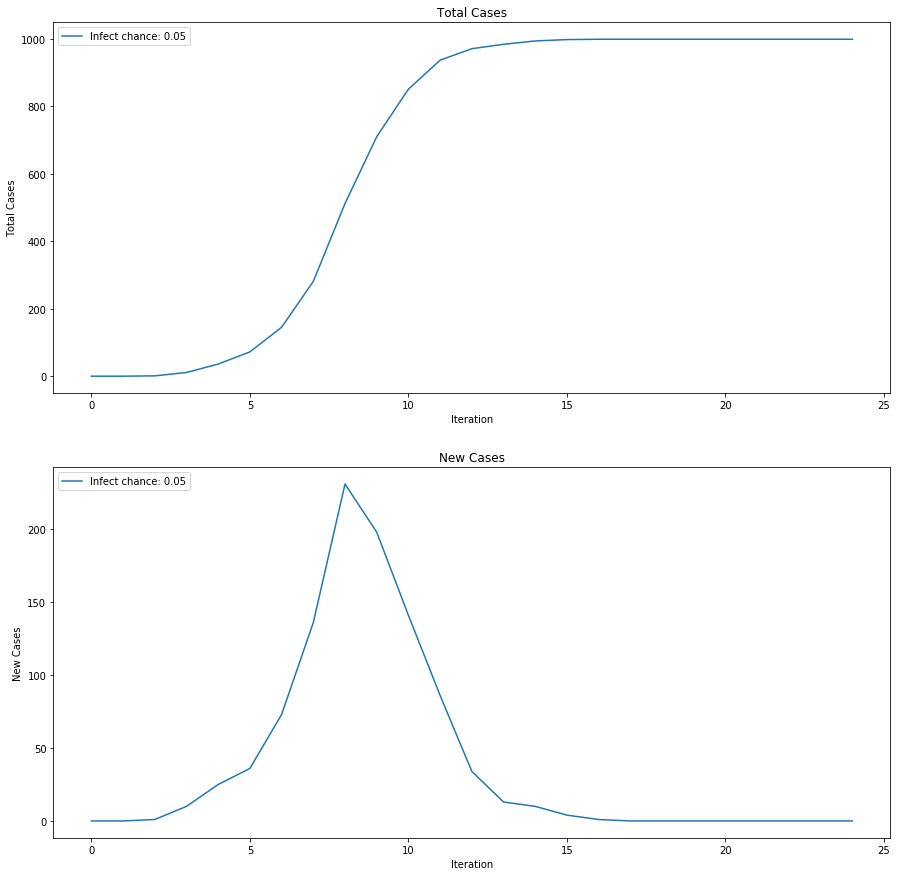

In [95]:
fig, a =  plt.subplots(2, figsize=(15,15))
x, y = [case[0] for case in total_cases], [case[1] for case in total_cases]
a[0].plot(x,y, label="Infect chance: {}".format(infect_p))
a[0].set_title("Total Cases")
a[0].set_xlabel("Iteration")
a[0].set_ylabel("Total Cases")
a[0].legend(loc="upper left")

x, y = [case[0] for case in new_cases], [case[1] for case in new_cases]
a[1].plot(x,y, label="Infect chance: {}".format(infect_p))
a[1].set_title("New Cases")
a[1].set_xlabel("Iteration")
a[1].set_ylabel("New Cases")
a[1].legend(loc="upper left")
plt.show()